# How I Warped Your Noise: Unoffical implementation

This notebook is unoffical implementation of integral noise warping methodology described introduced by Chang et al. in ICLR 2024 paper, "**How I Warped Your Noise: a Temporally-Correlated Noise Prior for Diffusion Models**".

----------


Implemented by [Min-Seop Kwak](https://mskwak01.github.io/).

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import nvdiffrast.torch as dr

from IPython.display import Image
from torchvision.transforms import ToPILImage
from torchvision.transforms import RandomPerspective
from einops import rearrange, reduce, repeat

to_img = ToPILImage()


/home/cvlab15/anaconda3/envs/threefuse/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


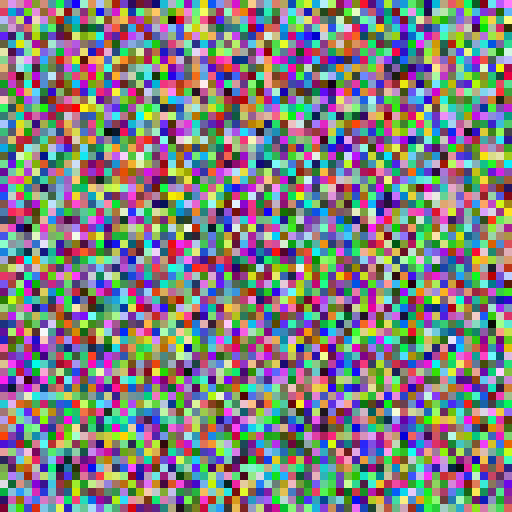

In [3]:
# Sample the source noise, channel = 3

up_level = 3   # Upsampling level k
batch_size = 1 # Batch size
dim_channel = 3    # Channel dimension
H = 64   # Original H
W = 64   # Original W

src_noise = torch.randn(batch_size,dim_channel,H,W)

# Upscale to 512 x 512 and visualize, just for visualization purposes

view_test_noise = F.interpolate(src_noise, size=(512,512), mode='nearest')
to_img(view_test_noise[0])

In [4]:
def cond_noise_sampling(src_noise, level=3):

    B, C, H, W = src_noise.shape

    up_factor = 2 ** level

    upscaled_means = F.interpolate(src_noise, scale_factor=(up_factor, up_factor), mode='nearest')

    up_H = up_factor * H
    up_W = up_factor * W

    """
        1) Unconditionally sample a discrete Nk x Nk Gaussian sample
    """

    raw_rand = torch.randn(B, C, up_H, up_W)

    """
        2) Remove its mean from it
    """

    Z_mean = raw_rand.unfold(2, up_factor, up_factor).unfold(3, up_factor, up_factor).mean((4, 5))
    Z_mean = F.interpolate(Z_mean, scale_factor=up_factor, mode='nearest')
    mean_removed_rand = raw_rand - Z_mean

    """
        3) Add the pixel value to it
    """

    up_noise = upscaled_means / up_factor + mean_removed_rand

    return up_noise


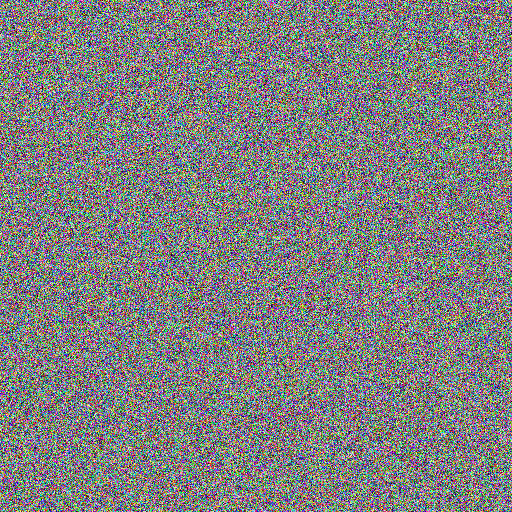

In [5]:
# Generate conditionally upsampled noise by k = up_level

up_noise = cond_noise_sampling(src_noise, level=up_level)


# Visualize upsampled noise

test_upsampled_noise_vis = F.interpolate(up_noise, size=(512,512), mode='nearest')
to_img(test_upsampled_noise_vis[0])

In [6]:
"""
  Defining the partitioned polygons for target noise map
"""

B, C, H, W = src_noise.shape

# Defining a 2x upscaled, partitioned pixel map with vertex index numbers for rasterization

tr_W = W * 2 + 1
tr_H = H * 2 + 1

i, j = torch.meshgrid(
        torch.arange(tr_W, dtype=torch.int32),
        torch.arange(tr_H, dtype=torch.int32),
        indexing="ij",
    )

mesh_idxs = torch.stack((i,j), dim=-1)
reshaped_mesh_idxs = mesh_idxs.reshape(-1,2)

# per_tri_verts defining 8 polygonal partitions for a single original pixel
front_tri_verts = torch.tensor([[0, 1, 1+tr_W], [0, tr_W, 1+tr_W], [tr_W, 1+tr_W, 1+2*tr_W], [tr_W, 2*tr_W, 1+2*tr_W]])
per_tri_verts = torch.cat((front_tri_verts, front_tri_verts + 1),dim=0)


# Defining 'starting vertex indices' representing original pixels at 2x upscaled pixel map
width = torch.arange(0, tr_W - 1, 2)
height = torch.arange(0, tr_H-1, 2) * (tr_W)
width_l = torch.linspace(0, tr_W-2, tr_W-1)

start_idxs = (width[None,...] + height[...,None]).reshape(-1,1)
vertices = (start_idxs.repeat(1,8)[...,None] + per_tri_verts[None,...]).reshape(-1,3)
num_faces = vertices.shape[0]

# print(width)
# print(height)
# print(start_idxs.shape)  --> size == original resolution's pixel num == H x W if correct
# print(vertices)


In [ ]:
"""
  Visualization of the code above. Something just like this
"""

'\n  Visualization of the code above. Something just like this\n'

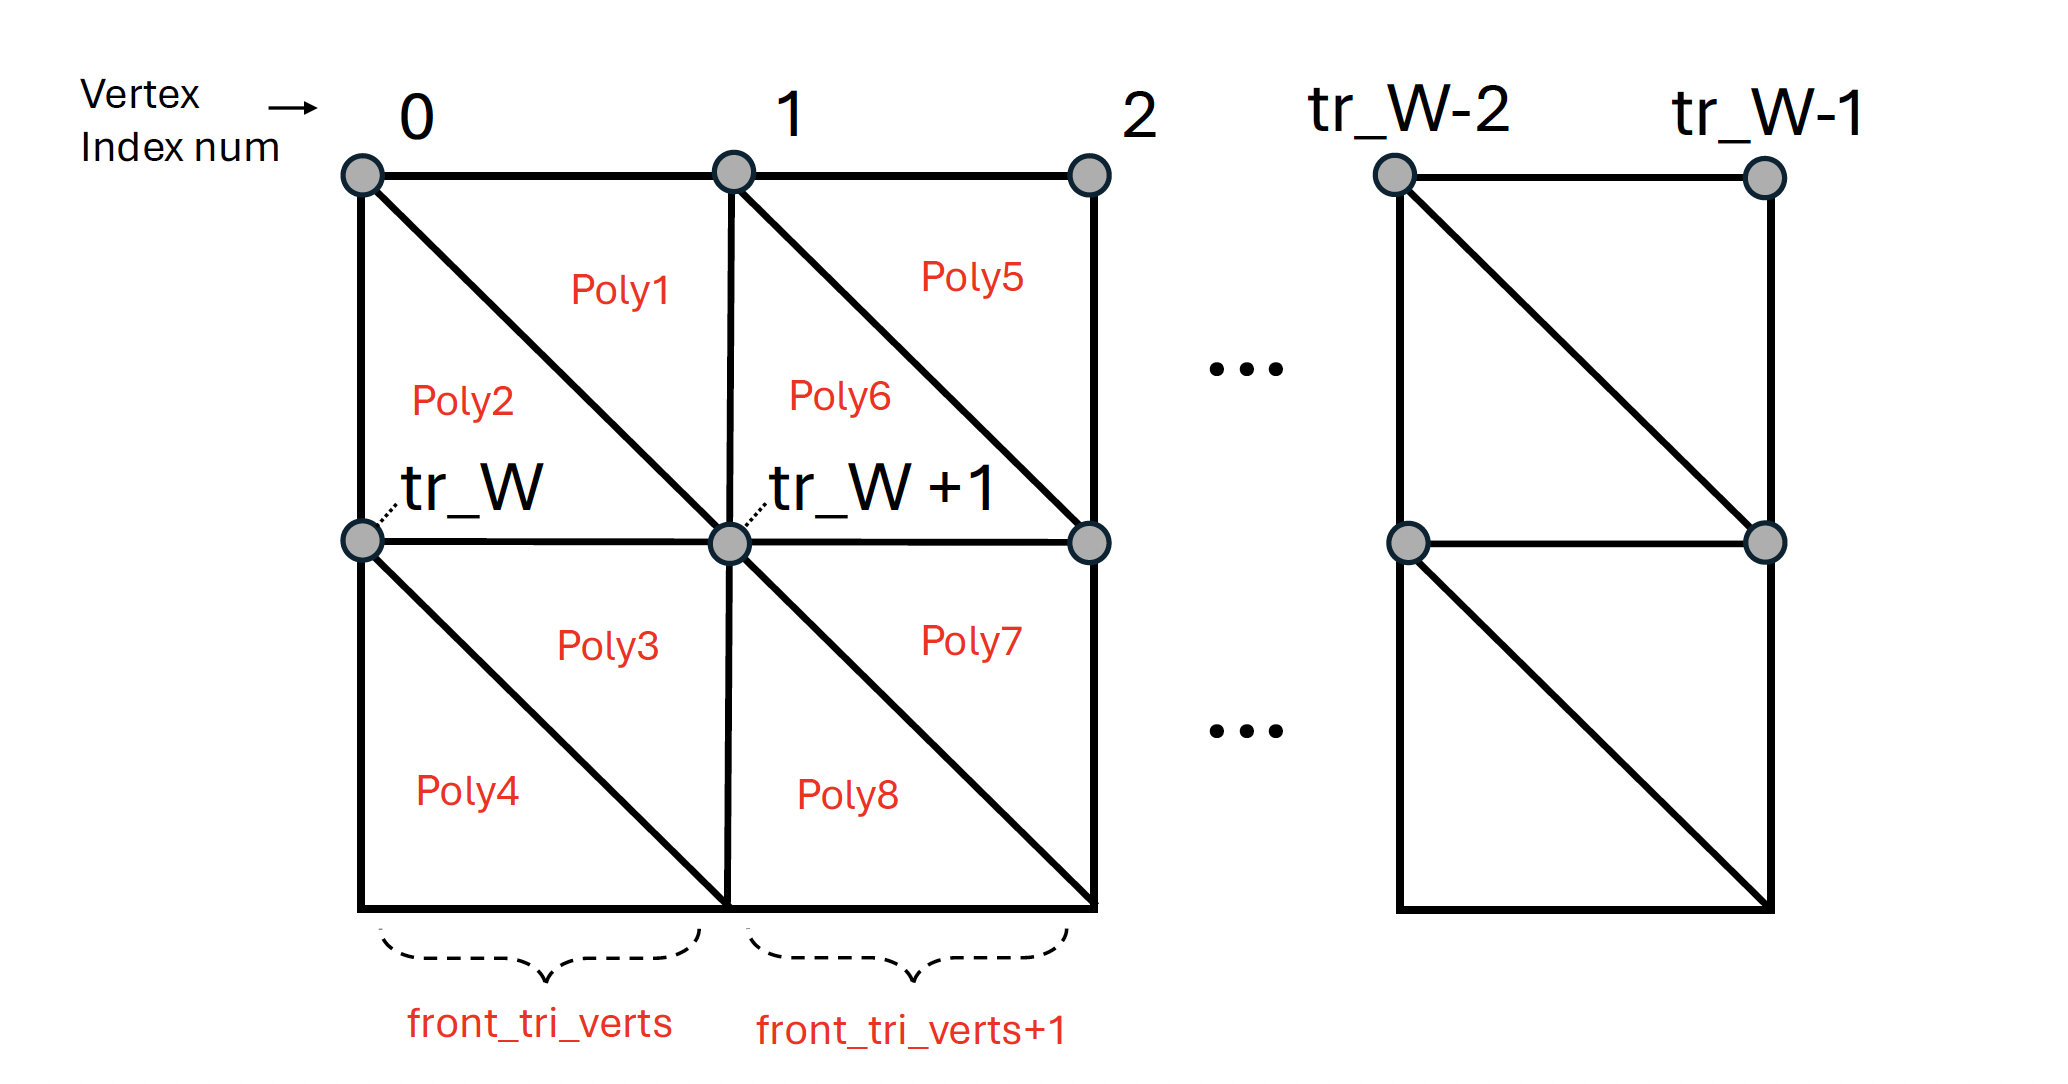

In [7]:
"""
  For testing, define a flow map the location where each vertex in 2x upscaled target pixel map
  corresponds to within the source noise map

  Test options: "identity_mapping" / "rotation"

"""

test_option = "rotation"

warp_i, warp_j = torch.meshgrid(
        torch.arange(W * 2 + 1),
        torch.arange(H * 2 + 1),
        indexing="ij",
    )

if test_option == "identity_mapping":
  warp_idxs = torch.stack((warp_i, warp_j), dim=-1)
  tgt_to_src_map = warp_idxs

elif test_option == "rotation":
  rotation_radian = 0.3
  warp_idxs =  (torch.stack((warp_i, warp_j), dim=-1) - torch.tensor([W,W])[None,None,...]) / 1
  deg = torch.tensor([rotation_radian])
  rotmat = torch.tensor([[torch.cos(deg), -torch.sin(deg)], [torch.sin(deg), torch.cos(deg)]])
  tgt_to_src_map = (rotmat[None,None,...] @ warp_idxs[...,None]).squeeze() * 1.0 + torch.tensor([W,W])[None,None,...]

else:
  print("config not yet defined")


In [8]:
idx_y = reshaped_mesh_idxs[:,0].int()
idx_x = reshaped_mesh_idxs[:,1].int()

# Nvdiffrast input must be (x,y), so it must be flipped!!
warped_coords = tgt_to_src_map[idx_y, idx_x].fliplr()
coords_len = idx_y.shape[0]

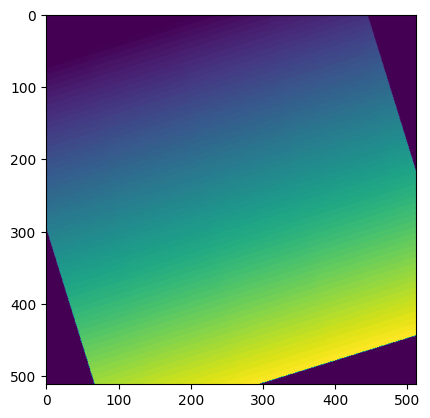

In [9]:
"""
    Triangle rasterization using Nvdiffrast
"""

resolution= H * (2 ** up_level)
device = "cuda"
use_opengl = False # On T4 GPU, only False works, but rasterizer works much better if = True
glctx = dr.RasterizeGLContext() if use_opengl else dr.RasterizeCudaContext()

warped_vtx_pos =torch.cat(((warped_coords - H) / H, torch.zeros(coords_len, 1), torch.ones(coords_len, 1)), dim=-1)

# To avoid ranged error
warped_vtx_pos = warped_vtx_pos[None,...].to(device)
vertices = vertices.int().to(device)

with torch.no_grad():
    rast_out, _ = dr.rasterize(glctx, warped_vtx_pos, vertices, resolution=[resolution, resolution])

rast = rast_out[:,:,:,3:].permute(0,3,1,2).to(torch.int64)

# Delete the context
del glctx

# Rasterization visualization
up_noise_vis = F.interpolate(rast.float(), size=(512,512), mode='nearest')

plt.imshow(rast[0,0].cpu().numpy())

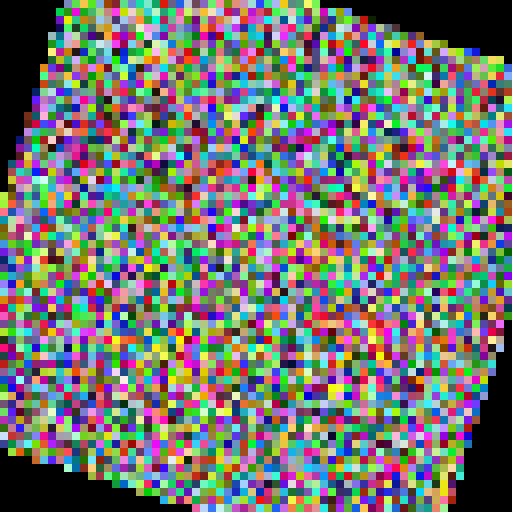

In [10]:
"""
  finding pixel indices in cond-upsampled map that belong to each polygon triangle,
  and then adding them up

  This implementation uses torch.scatter() to do this in parallel, so it is faster
"""

# Assign same index to triangles from the same original pixel, 0 if no index
indices = (rast - 1) // 8 + 1 # there is 8 triangles per pixel

# Flatten the upsampled noise
up_noise_flat = up_noise.reshape(B*C, -1).cpu()

# Create a flatten vector of ones for "Cardinality" value i.e. number of contained pixels
ones_flat = torch.ones_like(up_noise_flat[:1])

# Flatten the indices (and broadcast to batch size)
indices_flat = indices.reshape(1, -1).cpu().to(torch.int64)

# Aggregate the noise values and cardinality using scattering operation
fin_v_val = torch.zeros(B*C, H*W+1).scatter_add_(1, index=indices_flat.repeat(B*C, 1), src=up_noise_flat)[..., 1:]
fin_v_num = torch.zeros(1, H*W+1).scatter_add_(1, index=indices_flat, src=ones_flat)[..., 1:]

final_values = fin_v_val / torch.sqrt(fin_v_num)

warped_noise_fast = final_values.reshape(B, C, H, W).float()

up_vis_fast = F.interpolate(warped_noise_fast, size=(512,512), mode='nearest')
to_img(up_vis_fast[0])

true


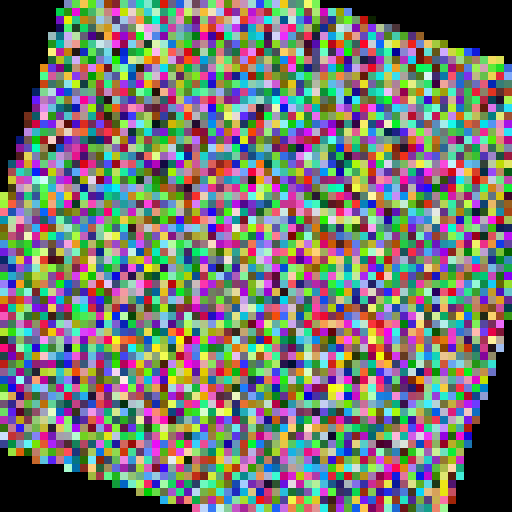

In [11]:
"""
    Slower implementation, finding pixel indices in cond-upsampled map that belong to each polygon triangle,
    and then adding them up

    This implementation does it sequentially for each traingle mesh index using for loop
   - computationally cheap, but takes a lot of time.
"""

uni_idx = torch.unique(rast).to(device)

if uni_idx[0] == 0:
    # if there is a 0 for index value, it is from empty (unmapped) locations, so must be eliminated
    print("true")
    uni_idx = uni_idx[1:]

vert_canvas = torch.zeros((B,C,num_faces + 1)) # will be used to aggregate all values
vert_canvas_num_idx = torch.zeros((B,C,num_faces + 1)) # counting for "Cardinality" value i.e. number of contained pixels

for value, idx in enumerate(uni_idx):
    val_indice = torch.nonzero(rast == idx)

    id = uni_idx[value]

    for k in val_indice:
        vert_canvas[...,id] += up_noise[...,k[2],k[3]]
        vert_canvas_num_idx[...,id] += 1

reshaped_v = vert_canvas[...,1:].reshape(B,C,-1,8)
reshaped_v_num = vert_canvas_num_idx[...,1:].reshape(B,C,-1,8)

fin_v_val = reshaped_v.sum(dim=-1)
fin_v_num = reshaped_v_num.sum(dim=-1)

final_values = fin_v_val / torch.sqrt(fin_v_num)

warped_noise_slow = final_values.reshape(B,C,H,W).float()

# Visualize the warped noise
# if test_option == "identity", this must be identical to source noise visualization above

up_vis = F.interpolate(warped_noise_slow, size=(512,512), mode='nearest')
to_img(up_vis[0])


In [ ]:
"""
  "And that, dear reader, is how we warped your noise."
"""